# **Cluster Analysis on Batter Projections**

## Summary

This notebook gathers full season batting projections and runs a k-means cluster analysis to group players into tiers.  The tiers inform my draft strategy for batters, which contribute to the following categories.  Ideally, I am looking for a tier that represents the best batters in the draft.  This should be evident by the top tier's relative dominance across the five categories below. 

* Runs (R)
* Home Runs (HR)
* Runs Batted In (RBI)
* Stolen Bases (SB)
* Batting Average (AVG)

More details about the league, scoring, etc can be found in the [README](../fantasy_baseball/README.md). 

The elbow method suggested that three clusters should be ideal.  From a practical standpoint, I wanted a top tier with fewer players included, so I increased the cluster count iteratively until I found a level that produced the desired results.  There were 61 players in the top tier (cluster_num = 4).  This allowed me to focus my draft strategy on maximizing the number of selections from this tier.

## Contents
* Import Data
* K-Means Clustering
* Evaluation
* Export Data

---
# **Environment**

In [36]:
# General Usage
import pandas as pd
import numpy as np

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_blobs

# Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

---
# **Import Data**

In [2]:
# import 2021 projections
projections_df = pd.read_csv('2021_batting_projections.csv')

In [3]:
# review dataset
projections_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    608 non-null    object 
 1   HR      608 non-null    int64  
 2   R       608 non-null    int64  
 3   RBI     608 non-null    int64  
 4   SB      608 non-null    int64  
 5   AVG     608 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 28.6+ KB


In [4]:
# check top 10 records
projections_df.head(10)

,Name,HR,R,RBI,SB,AVG
0,Mike Trout,44,116,113,11,0.290
1,Juan Soto,35,107,107,11,0.299
2,Freddie Freeman,31,103,102,7,0.300
3,Christian Yelich,35,105,103,18,0.285
4,Bryce Harper,35,102,102,13,0.267
5,Mookie Betts,33,111,102,20,0.292
6,Cody Bellinger,38,106,108,14,0.278
7,Alex Bregman,31,99,97,5,0.277
8,Ronald Acuna Jr.,36,112,99,30,0.280
9,Aaron Judge,35,90,87,4,0.257


---
# **K-Means Clustering**

In [5]:
# capture statistical categories for cluster analysis
categories = projections_df.columns[1:]

In [6]:
# empty list for cost function results
distortions = []

# run k-means for 1 to 10 clusters
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k, random_state=22)
    kmeanModel.fit(projections_df[categories])
    distortions.append(kmeanModel.inertia_)

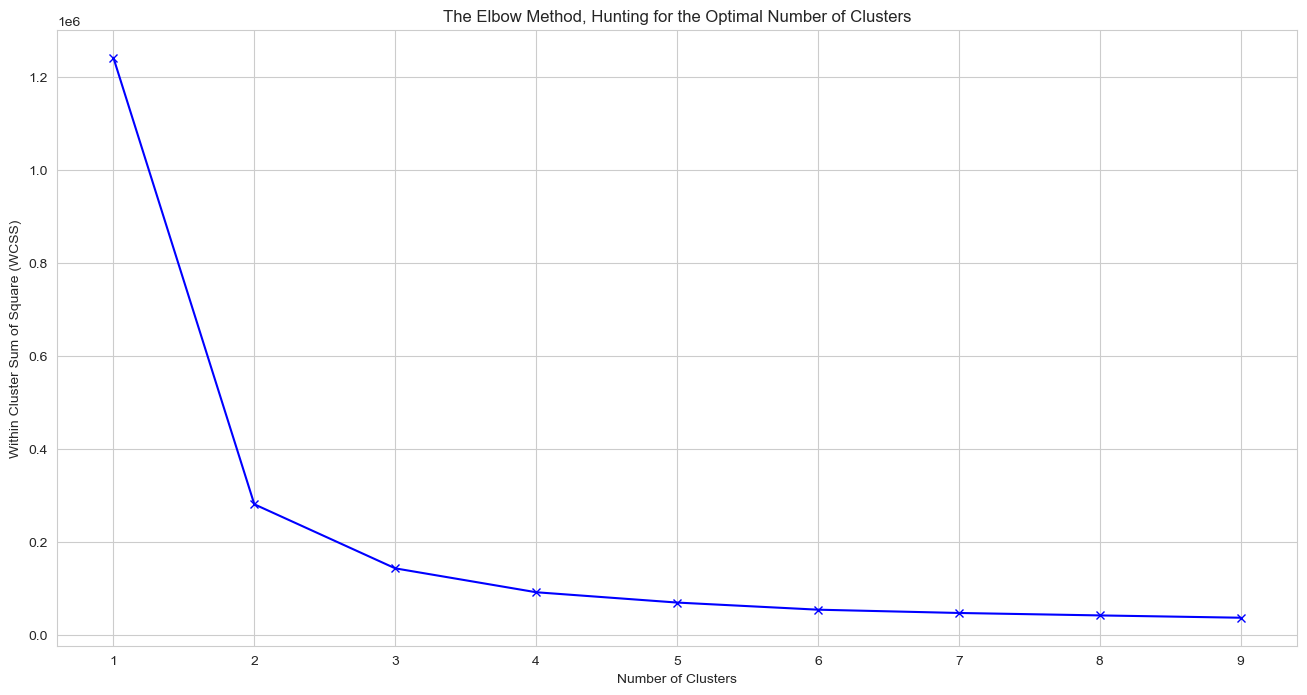

In [25]:
# plotting the cost function to evaluate the optimal k
sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Square (WCSS)')
plt.title('The Elbow Method, Hunting for the Optimal Number of Clusters')
plt.show()

In [47]:
# loop over range for the number of clusters and calculate silhouette score for each cluster value
for k in range(2,10):
    kmeans_temp = KMeans(n_clusters=k, random_state=22)
    kmeans_temp.fit(projections_df[categories])
    preds = kmeans_temp.predict(projections_df[categories])
    s_score = round(silhouette_score(projections_df[categories], preds), 3)
    print("For " + str(k) + " clusters, the silhouette score is: " + str(s_score))

For 2 clusters, the silhouette score is: 0.663
For 3 clusters, the silhouette score is: 0.596
For 4 clusters, the silhouette score is: 0.557
For 5 clusters, the silhouette score is: 0.527
For 6 clusters, the silhouette score is: 0.51
For 7 clusters, the silhouette score is: 0.506
For 8 clusters, the silhouette score is: 0.502
For 9 clusters, the silhouette score is: 0.483


In [30]:
# initialize K-Means model with 5 clusters
kmeans_mod = KMeans(n_clusters=5, random_state=22)

# fit model using projections
kmeans_mod.fit(projections_df[categories])

KMeans(n_clusters=5, random_state=22)

---
# **Evaluation**

In [31]:
# add cluster number to a new column
projections_df['cluster_num']=kmeans_mod.predict(projections_df[categories])

In [32]:
# review clustering results
projections_df.head(10)

,Name,HR,R,RBI,SB,AVG,cluster_num
0,Mike Trout,44,116,113,11,0.290,4
1,Juan Soto,35,107,107,11,0.299,4
2,Freddie Freeman,31,103,102,7,0.300,4
3,Christian Yelich,35,105,103,18,0.285,4
4,Bryce Harper,35,102,102,13,0.267,4
5,Mookie Betts,33,111,102,20,0.292,4
6,Cody Bellinger,38,106,108,14,0.278,4
7,Alex Bregman,31,99,97,5,0.277,4
8,Ronald Acuna Jr.,36,112,99,30,0.280,4
9,Aaron Judge,35,90,87,4,0.257,4


In [33]:
# review player counts by cluster
projections_df.cluster_num.value_counts()

3    225
1    132
2    102
0     88
4     61
Name: cluster_num, dtype: int64

In [34]:
# review average projections by cluster
projections_df.groupby('cluster_num').mean()

,HR,R,RBI,SB,AVG
cluster_num,,,,,
0,20.931818,73.227273,71.965909,7.000000,0.253909
1,6.712121,27.765152,26.492424,2.931818,0.234712
2,12.450980,54.843137,50.941176,6.490196,0.247265
3,1.173333,5.662222,5.253333,0.524444,0.227738
4,30.803279,90.672131,92.098361,9.098361,0.266770


---
# **Export Data**

In [22]:
# export projections with clusters
projections_df.sort_values(by='cluster_num', ascending=False).to_csv('kmeans_output.csv', index=False)